In [90]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np

In [91]:
# CUMULATIVE DATA -> daily cumulative data
all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_death_by_county.csv")
all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_infection_county_cases.csv")
all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

In [92]:
# # CUMULATIVE DATA -> weekly data
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_weeky_death.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_weekly_infection.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

In [93]:
all_county_exemption_rates = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\exemption_rates.xlsx")
all_county_population = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\county_size_N.xlsx")

In [94]:
efficacy = 0.95 # measles vaccine efficacy (average of cdc stats for 1 and 2 doses)
county_name = 'Texas'

deaths = all_county_deaths.set_index('date')[county_name]
infected = all_county_infected.set_index('date')[county_name]

exemption = all_county_exemption_rates[all_county_exemption_rates['County'] == county_name]
exemption_val = float(exemption['Exemption Rate'].values[0])

population = all_county_population[all_county_population['County'] == county_name]
pop_val = int(population['Population'].values[0])

# S0 = N*(exemption_val+((1-exemption_val)*(1-efficacy)))
print(exemption_val)
print(pop_val)

0.023806573819859345
31290831


In [95]:
merged_df = pd.concat([infected.rename("Cumulative Infected"), 
                       deaths.rename("Cumulative Deaths")], axis=1)

merged_df = merged_df.reset_index().rename(columns={'index': 'Date'})

# print(merged_df.head())
# print(merged_df.columns.tolist())

Simulation

In [96]:
H = np.array([
    [0, 0, 0, 0, 1],  # infected I
    [0, 0, 0, 1, 0],  # deaths D
], dtype=float)  

n_ens = 500
dt = 1.0

alpha = 1.2
tol = 1e-3
ens_perturb = 0.2

beta_low, beta_high = 0, 1
gamma_low, gamma_high = 0.05, 0.2 # recovery rate 
delta_low, delta_high = 0, 0.01
N = pop_val*(exemption_val+((1-exemption_val)*(1-efficacy)))
# N = pop_val
R0 = 0

In [97]:
I0 = int(merged_df['Cumulative Infected'].iloc[0])
D0 = int(merged_df['Cumulative Deaths'].iloc[0])
C0 = int(merged_df['Cumulative Infected'].iloc[0])
S0 = max(N - (I0 + R0 + D0), 0)

x0_mean = np.array([S0, I0, R0, D0, C0])

def R_from_obs(y_vec):
    y = np.asarray(y_vec, dtype=float)
    floors = np.array([0.005, 0.001])     # min std for C and D
    sigma  = np.maximum(0.5*np.maximum(y, 1.0), floors)
    return np.diag(sigma**2)

def sird_step_aug(state_aug, N, dt):
    S, I, R, D, C, beta, gamma, delta = state_aug
    new_infections = beta * S * I / N 
    dS = -new_infections
    dI = new_infections - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)
    C_new = C + new_infections

    beta_new = beta + np.random.normal(0, 0.0002)
    gamma_new = gamma + np.random.normal(0, 0.0002)
    delta_new = delta + np.random.normal(0, 0.0002)

    # constrain parameters to valid ranges
    beta_new = np.clip(beta_new, 0, 1)
    gamma_new = np.clip(gamma_new, 0, 1)
    delta_new = np.clip(delta_new, 0, 1)

    return np.array([S_new, I_new, R_new, D_new, C_new, beta_new, gamma_new, delta_new])


def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1:4].sum(axis=1)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:4] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def predict_measurement(state_ensemble):
    C = state_ensemble[:, 4]
    D = state_ensemble[:, 3]
    return np.column_stack([C, D])

def clean_nans(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]

In [98]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

def run_enkf_for_seed(sim_seed, beta_low, beta_high):
    rng = np.random.default_rng(sim_seed)
    Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()

    state_ens = np.zeros((n_ens, 8))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=4)
        IRD = np.maximum(x0_mean[1:4] * perturb[:3], 0)
        S = max(N - IRD.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        C = x0_mean[4]
        state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

    state_ens[:, 1] -= np.mean(state_ens[:, 1])
    state_ens[:, 1] += I0
    state_ens[:, 4] -= np.mean(state_ens[:, 4])
    state_ens[:, 4] += C0

    state_ens = enforce_mass(state_ens, N)

    n_timesteps = len(merged_df)
    ensemble_states_hist = np.full((n_timesteps, n_ens, 5), np.nan)
    ensemble_params_hist = np.full((n_timesteps, n_ens, 3), np.nan)

    max_passes = 10
    pass_idx = 0
    total_cycles = 0
    converged = False
    converged_day = None
    converg_counter = 0

    while pass_idx < max_passes and not converged:
        pass_idx += 1
        converged_day = None

        for k in range(n_timesteps):
            total_cycles += 1

            if k > 0:
                # Forecast step: propagate prior ensembles from previous posterior
                for i in range(n_ens):
                    state_ens[i] = sird_step_aug(state_ens[i], N, dt)
                state_ens = enforce_mass(state_ens, N)

            # Predict measurement and compute Kalman gain
            meas_pred = predict_measurement(state_ens)  
            y_obs_k = Y_obs[k]
            Rk = R_from_obs(y_obs_k)

            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            aug_ens = np.hstack([state_ens])
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)

            X = aug_ens - aug_mean
            Y = meas_pred - meas_mean
            C_xy = (X.T @ Y) / (n_ens - 1)
            C_yy = (Y.T @ Y) / (n_ens - 1)

            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                state_ens[i] = aug_update
            state_ens = enforce_mass(state_ens, N)

            if k > 0:
                last_obs_C = Y_obs[k-1, 0]
                state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

            # Store updated (posterior) ensemble for time k
            ensemble_states_hist[k] = state_ens[:, :5]  
            ensemble_params_hist[k] = state_ens[:, 5:]
            state_ens[:, 1] = I0
            state_ens[:, 4] = C0

            mean_beta = np.mean(state_ens[:, 5])
            mean_gamma = np.mean(state_ens[:, 6])
            mean_delta = np.mean(state_ens[:, 7])
            print(f"Day {k}: Mean beta={mean_beta:.4f}, gamma={mean_gamma:.4f}, delta={mean_delta:.4f}")

            # Check parameter convergence
            if k > 0:
                prev_mean_theta = np.mean(ensemble_params_hist[k-1], axis=0)
                curr_mean_theta = np.mean(state_ens[:, 5:], axis=0)
                rel_change = np.linalg.norm(curr_mean_theta - prev_mean_theta, ord=np.inf) / (np.linalg.norm(prev_mean_theta) + 1e-9)
                if rel_change < tol:
                    converg_counter += 1
                    if converg_counter >= 1:
                        converged_day = k
                else:
                    converg_counter = 0

        last_day = converged_day if converged_day is not None else n_timesteps - 1
        mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)

        if converged_day is not None:
            converged = True
        
        predicted_C = mean_states[: last_day + 1, 4]  
        actual_C = merged_df['Cumulative Infected'].to_numpy()[: last_day + 1]  

    actual_C = Y_obs[: last_day + 1, 0]   # cumulative infections (I + R + D)
    actual_D = Y_obs[: last_day + 1, 1]

    pred_I = mean_states[: last_day + 1, 1]
    pred_R = mean_states[: last_day + 1, 2]
    pred_D = mean_states[: last_day + 1, 3]
    
    delta_I = np.diff(pred_I, prepend=pred_I[0])
    delta_R = np.diff(pred_R, prepend=pred_R[0])
    delta_D = np.diff(pred_D, prepend=pred_D[0])

    # monotone increasing 
    delta_I = np.maximum(delta_I, 0)
    delta_R = np.maximum(delta_R, 0)
    delta_D = np.maximum(delta_D, 0)

    actual_C, predicted_C = clean_nans(actual_C, predicted_C)
    actual_D, pred_D = clean_nans(actual_D, pred_D)
    
    rmse_C = np.sqrt(root_mean_squared_error(actual_C, predicted_C))
    r2_C = r2_score(actual_C, predicted_C)
    rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
    r2_D = r2_score(actual_D, pred_D)
    
    print(f"Cumulative Infected: RMSE {rmse_C:.2f}, R^2 {r2_C:.4f}")
    print(f"Cumulative Deaths: RMSE {rmse_D:.2f}, R^2 {r2_D:.4f}")

    return {
        'rmse_C': rmse_C,
        'r2_C': r2_C,
        'rmse_D': rmse_D,
        'r2_D': r2_D,
        'total_cycles': total_cycles,
        'converged_day': converged_day,
        'mean_states': mean_states,
        'cumulative_predicted_infections': predicted_C,
        'predicted I': pred_I,
        'ensemble_states_hist': ensemble_states_hist,
        'predicted recoveries': pred_R,
        'predicted deaths': pred_D,
        'ensemble_params_hist': ensemble_params_hist
    }


In [99]:
seeds = np.arange(10, 15)  # not inclusive of 40

results = []
for seed in seeds:
    res = run_enkf_for_seed(seed, beta_low, beta_high)
    results.append(res)

# for beta_low, beta_high in beta_ranges:
#     for seed in seeds:
#         res = run_enkf_for_seed(seed, beta_low, beta_high)
#         res['beta_low'] = beta_low
#         res['beta_high'] = beta_high
#         res['seed'] = seed
#         results.append(res)
        
# Extract metrics from results
total_cycles_list = [r['total_cycles'] for r in results]
rmse_C_list = [r['rmse_C'] for r in results]
r2_C_list   = [r['r2_C'] for r in results]
rmse_D_list = [r['rmse_D'] for r in results]
r2_D_list   = [r['r2_D'] for r in results]
result = results[2]
ensemble_states_hist = result['ensemble_states_hist']


Day 0: Mean beta=0.5086, gamma=0.1271, delta=0.0049
Day 1: Mean beta=0.4883, gamma=0.1265, delta=0.0037
Day 2: Mean beta=0.4638, gamma=0.1258, delta=0.0020
Day 3: Mean beta=0.4537, gamma=0.1249, delta=0.0011
Day 4: Mean beta=0.4729, gamma=0.1238, delta=0.0008
Day 5: Mean beta=0.4904, gamma=0.1230, delta=0.0006
Day 6: Mean beta=0.5036, gamma=0.1222, delta=0.0005
Day 7: Mean beta=0.5090, gamma=0.1214, delta=0.0004
Day 8: Mean beta=0.5239, gamma=0.1224, delta=0.0007
Day 9: Mean beta=0.5424, gamma=0.1206, delta=0.0005
Day 10: Mean beta=0.5568, gamma=0.1192, delta=0.0004
Day 11: Mean beta=0.5811, gamma=0.1185, delta=0.0004
Day 12: Mean beta=0.6011, gamma=0.1179, delta=0.0004
Day 13: Mean beta=0.6200, gamma=0.1175, delta=0.0004
Day 14: Mean beta=0.6390, gamma=0.1170, delta=0.0004
Day 15: Mean beta=0.6605, gamma=0.1165, delta=0.0003
Day 16: Mean beta=0.6777, gamma=0.1164, delta=0.0003
Day 17: Mean beta=0.6975, gamma=0.1160, delta=0.0003
Day 18: Mean beta=0.7149, gamma=0.1158, delta=0.0003
Day

In [100]:
all_params = [r['ensemble_params_hist'] for r in results]  # shape: (#seeds, timesteps, n_ens, 3)

combined_params = np.concatenate(all_params, axis=1)  # concatenate ensembles axis (axis=1)

mean_params_across_ensembles_and_seeds = np.mean(combined_params, axis=1)  # shape (timesteps, 3)

mean_beta_over_time = mean_params_across_ensembles_and_seeds[:, 0]
mean_gamma_over_time = mean_params_across_ensembles_and_seeds[:, 1]
mean_delta_over_time = mean_params_across_ensembles_and_seeds[:, 2]

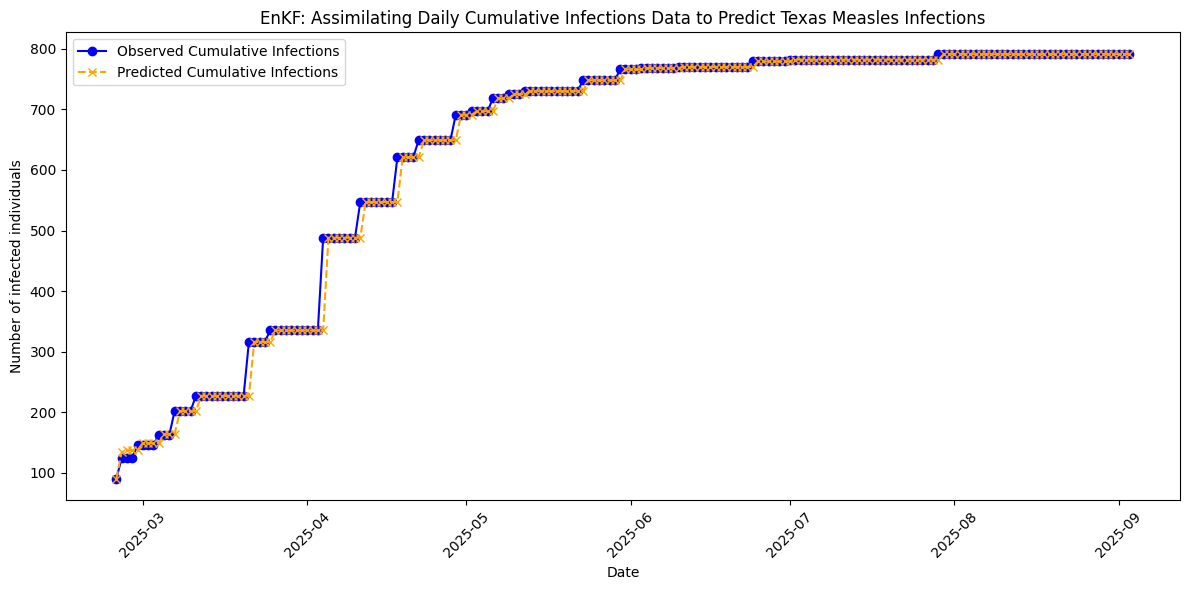

In [101]:
predicted_C = np.nanmean(ensemble_states_hist[:, :, 4], axis=1)  # mean over ensembles for each day
actual_C = merged_df['Cumulative Infected'].to_numpy()

dates = merged_df['date']

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_C, 'o-', label='Observed Cumulative Infections', color='blue')
plt.plot(dates, predicted_C, 'x--', label='Predicted Cumulative Infections', color='orange')
plt.xlabel("Date")
plt.ylabel("Number of infected individuals")
plt.title("EnKF: Assimilating Daily Cumulative Infections Data to Predict Texas Measles Infections")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [102]:
import pandas as pd

# Assuming 'ensemble_states_hist' shape is (timesteps, ensemble_size, 5)
# Get mean predicted cumulative infections (C column index 4) for all timesteps (full simulation length)
mean_predicted_cum_inf = ensemble_states_hist[:, :, 4].mean(axis=1)

# Get dates for the full length of ensemble_states_hist
dates = merged_df['date'].iloc[:len(mean_predicted_cum_inf)].reset_index(drop=True)

# Get true cumulative infections for full simulation length
true_cum_inf = merged_df['Cumulative Infected'].iloc[:len(mean_predicted_cum_inf)].reset_index(drop=True)

# Create a new DataFrame
df_save = pd.DataFrame({
    'date': dates,
    'ENKF Predicted': mean_predicted_cum_inf,
    'True Infections': true_cum_inf
})

# Save to CSV at the specified path (make sure directory exists)
csv_path = r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\cum_daily.csv"
df_save.to_csv(csv_path, index=False)

print(f"Saved results to {csv_path}")


Saved results to C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\cum_daily.csv


first rows: obs  analyzed
0 90 90.0
1 124 133.70167802195053
2 124 137.90703497526076
3 124 137.2635891902692
4 146 137.4391261416819
5 146 148.96480168704318
6 146 149.20085639100765
7 146 149.15231906128898
8 163 149.42547766706014
9 163 163.5837308067216
10 163 163.751431567364
11 202 163.85807263206382


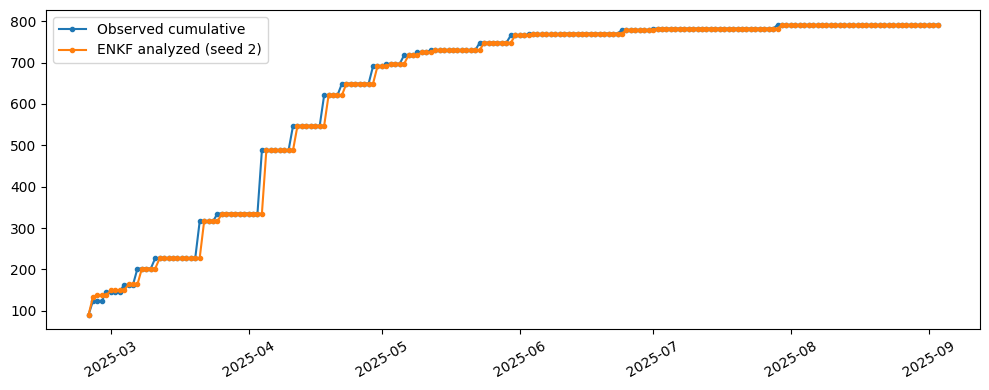

In [103]:
import numpy as np, matplotlib.pyplot as plt

seed_idx = 2                 # index in results (0..len(results)-1)
res = results[seed_idx]

# analyzed mean states (posterior after assimilation at each time)
analyzed = res['mean_states']         # shape (T, 5)
obs = merged_df['Cumulative Infected'].to_numpy()[:len(analyzed)]
dates = merged_df['date'].to_numpy()[:len(analyzed)]

print("first rows: obs  analyzed")
for t in range(min(12, len(analyzed))):
    print(t, obs[t], analyzed[t,4])

plt.figure(figsize=(10,4))
plt.plot(dates, obs, ".-", label="Observed cumulative")
plt.plot(dates, analyzed[:,4], ".-", label=f"ENKF analyzed (seed {seed_idx})")
plt.legend(); plt.xticks(rotation=30); plt.tight_layout(); plt.show()


# how greeks change over time

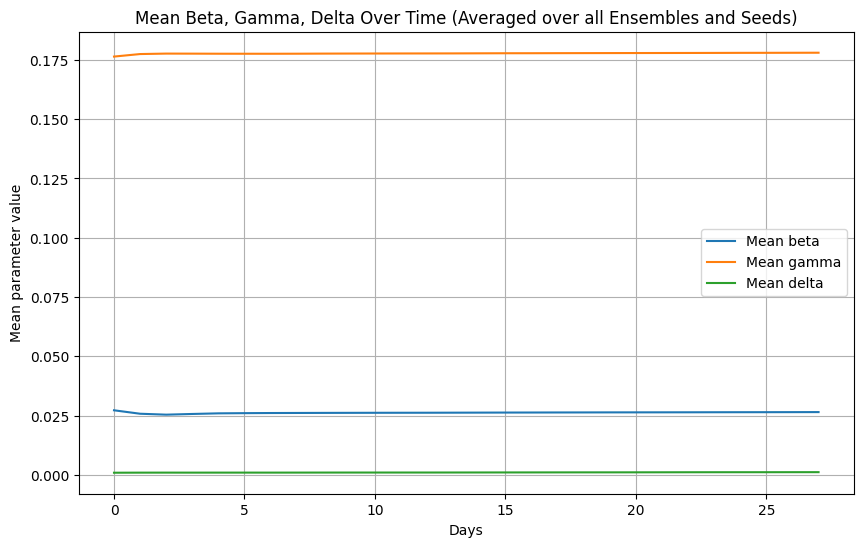

In [60]:
import matplotlib.pyplot as plt

days = np.arange(len(mean_beta_over_time))

plt.figure(figsize=(10, 6))
plt.plot(days, mean_beta_over_time, label='Mean beta')
plt.plot(days, mean_gamma_over_time, label='Mean gamma')
plt.plot(days, mean_delta_over_time, label='Mean delta')
plt.xlabel('Days')
plt.ylabel('Mean parameter value')
plt.title('Mean Beta, Gamma, Delta Over Time (Averaged over all Ensembles and Seeds)')
plt.legend()
plt.grid(True)
plt.show()


# roll over testing

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon, sim_seed):

    rng = np.random.default_rng(sim_seed)

    # --- init ensemble from your priors ---
    state_ens = np.zeros((n_ens, 8))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=4)
        IRD = np.maximum(x0_mean[1:4] * perturb[:3], 0)
        S = max(N - IRD.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        C = x0_mean[4]
        state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

    # --- assimilate up to cap_idx ---
    ensemble_states_hist = np.full((cap_idx + 1, n_ens, 5), np.nan)
    for k in range(cap_idx + 1):
        # Forecast step
        for i in range(n_ens):
            state_ens[i] = sird_step_aug(state_ens[i], N, dt)
        state_ens = enforce_mass(state_ens, N)

        # Update step with obs at k
        meas_pred = predict_measurement(state_ens)        # (n_ens, 2) for [C, D]
        y_obs_k   = Y_obs[k]                              # length-2 vector
        Rk        = R_from_obs(y_obs_k)
        obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

        aug_ens   = state_ens.copy()
        aug_mean  = np.mean(aug_ens, axis=0)
        meas_mean = np.mean(meas_pred, axis=0)

        X   = aug_ens - aug_mean
        Y   = meas_pred - meas_mean
        Cxy = (X.T @ Y) / (n_ens - 1)
        Cyy = (Y.T @ Y) / (n_ens - 1)
        Kk  = Cxy @ np.linalg.inv(Cyy + Rk)

        for i in range(n_ens):
            innovation = obs_perturbed[i] - meas_pred[i]
            aug_update = aug_ens[i] + alpha * (Kk @ innovation)
            state_ens[i] = aug_update

        state_ens = enforce_mass(state_ens, N)

        # keep C monotone vs previous observation (your safety)
        if k > 0:
            last_obs_C = Y_obs[k-1, 0]
            state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

        ensemble_states_hist[k] = state_ens[:, :5]

    # --- pure forecast for `horizon` steps ---
    forecast_states_hist = np.full((horizon, n_ens, 5), np.nan)
    last_obs_C = Y_obs[cap_idx, 0]
    for h in range(horizon):
        for i in range(n_ens):
            state_ens[i] = sird_step_aug(state_ens[i], N, dt)
        state_ens = enforce_mass(state_ens, N)
        state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)
        forecast_states_hist[h] = state_ens[:, :5]

    train_mean_states    = np.nanmean(ensemble_states_hist, axis=1)   # (cap_idx+1, 5)
    forecast_mean_states = np.nanmean(forecast_states_hist, axis=1)   # (horizon, 5)
    return train_mean_states, forecast_mean_states


def sliding_rollover(cap_date_str='2025-05-25', max_horizon=15, seeds=np.arange(10,15)):
    """Run the whole sliding process and return paths with averaged forecasts across seeds."""
    dates = merged_df['date'].to_numpy()
    Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()

    cap_date = pd.to_datetime(cap_date_str)
    mask = dates <= cap_date
    if not np.any(mask):
        raise ValueError(f"No data on/before {cap_date_str}")
    base_cap_idx = np.where(mask)[0][-1]

    paths = []   # list of dicts, one per iteration
    for step_ahead in range(0, max_horizon):  # 0..H-1
        cap_idx   = base_cap_idx + step_ahead
        horizon   = max_horizon - step_ahead
        if cap_idx >= len(dates) or horizon <= 0:
            break

        # average across seeds
        seed_forecasts = []
        for s in seeds:
            _, f_states = enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon, sim_seed=s)
            seed_forecasts.append(f_states[:, 4])  # C column
        mean_forecast_C = np.mean(np.vstack(seed_forecasts), axis=0)

        # we’ll also keep a mean training curve (from the first seed) for plotting context
        t_states, _ = enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon, sim_seed=seeds[0])

        forecast_dates = pd.date_range(start=pd.Timestamp(dates[cap_idx]) + pd.Timedelta(days=1),
                                       periods=horizon, freq='D')
        paths.append({
            "cap_idx": cap_idx,
            "cap_date": dates[cap_idx],
            "horizon": horizon,
            "train_dates": dates[:cap_idx+1],
            "train_mean_C": t_states[:, 4],
            "forecast_dates": forecast_dates,
            "forecast_mean_C": mean_forecast_C
        })
    return paths


# ----------------- RUN -----------------
paths = sliding_rollover(cap_date_str='2025-05-25', max_horizon=10, seeds=np.arange(10,15))

actual_series = merged_df.set_index('date')["Cumulative Infected"]

for p in paths:
    cap_dt   = pd.to_datetime(p["cap_date"])
    horizon  = p["horizon"]
    f_dates  = p["forecast_dates"]
    fC       = p["forecast_mean_C"]
    t_dates  = p["train_dates"]
    tC       = p["train_mean_C"]

    # window bounds
    start_win = cap_dt - pd.Timedelta(days=14)
    end_win   = f_dates[-1] + pd.Timedelta(days=1)

    # restrict training curve to last 14 days for visibility
    mask_train = (t_dates >= start_win) & (t_dates <= cap_dt)
    t_dates_win = t_dates[mask_train]
    tC_win      = tC[mask_train]

    # observed over forecast window
    obs_on_f = actual_series.reindex(f_dates).values
    mask_obs = ~np.isnan(obs_on_f)

    # RMSE over window where obs exist
    rmse = np.sqrt(np.mean((fC[mask_obs] - obs_on_f[mask_obs])**2)) if mask_obs.any() else np.nan

    plt.figure(figsize=(11, 5))
    plt.plot(t_dates_win, tC_win, 'o-', label='Training cumulative infected', linewidth=2)
    plt.plot(f_dates, fC, 'x--', label=f'Forecast next {horizon} days', linewidth=2)
    if mask_obs.any():
        plt.plot(f_dates[mask_obs], obs_on_f[mask_obs], 'o-', label='Observed forecast period', linewidth=2)

    # visual cues
    plt.axvline(cap_dt, color='gray', linestyle='--', linewidth=1.5, label='Train cutoff date')
    plt.axvspan(cap_dt, end_win, color='gray', alpha=0.08)  # shade forecast region
    title = f"EnKF: Assimilating Daily Cumulative Infections Data to Forecast the next {horizon} Days"
    # if not np.isnan(rmse):
    #     title += f" | RMSE={rmse:.1f}"
    
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Cumulative Infected")
    plt.xlim([start_win, end_win])
    plt.grid(alpha=0.2)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

# infection true data plots

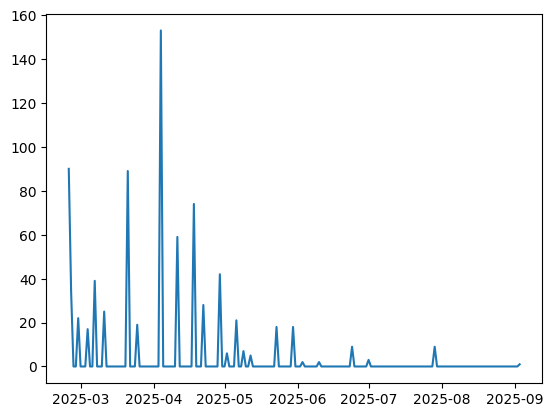

In [ ]:
df = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\infection_county_cases.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

plt.plot(df.index, df['Texas'])

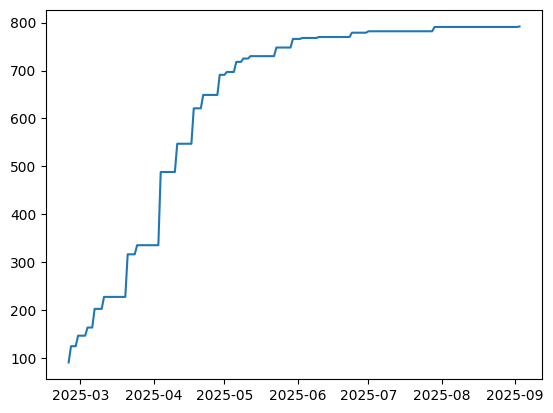

In [ ]:
df = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_infection_county_cases.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

plt.plot(df.index, df['Texas'])

# hidden markov and rollover

In [ ]:
# --- Kernel 1: Imports & Parameters ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

# --- User-defined parameters ---
train_end_str = '2025-04-10'   # last date to train initial ENKF + HMM
forecast_days = 20            # number of days to forecast
seeds = np.arange(10, 15)     # ensemble seeds
n_states = 2                   # 0=plateau, 1=growth


In [ ]:
# --- Kernel 2: ENKF train + forecast ---
def enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon, sim_seed):
    rng = np.random.default_rng(sim_seed)

    # --- initialize ensemble from priors ---
    state_ens = np.zeros((n_ens, 8))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=4)
        IRD = np.maximum(x0_mean[1:4] * perturb[:3], 0)
        S = max(N - IRD.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        C = x0_mean[4]
        state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

    # --- assimilate up to cap_idx ---
    ensemble_states_hist = np.full((cap_idx + 1, n_ens, 5), np.nan)
    for k in range(cap_idx + 1):
        for i in range(n_ens):
            state_ens[i] = sird_step_aug(state_ens[i], N, dt)
        state_ens = enforce_mass(state_ens, N)

        meas_pred = predict_measurement(state_ens)
        y_obs_k = Y_obs[k]
        Rk = R_from_obs(y_obs_k)
        obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

        aug_ens = state_ens.copy()
        aug_mean = np.mean(aug_ens, axis=0)
        meas_mean = np.mean(meas_pred, axis=0)

        X = aug_ens - aug_mean
        Y = meas_pred - meas_mean
        Cxy = (X.T @ Y) / (n_ens - 1)
        Cyy = (Y.T @ Y) / (n_ens - 1)
        Kk = Cxy @ np.linalg.inv(Cyy + Rk)

        for i in range(n_ens):
            innovation = obs_perturbed[i] - meas_pred[i]
            state_ens[i] = aug_ens[i] + alpha * (Kk @ innovation)

        state_ens = enforce_mass(state_ens, N)

        # keep cumulative infections monotone
        if k > 0:
            last_obs_C = Y_obs[k - 1, 0]
            state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

        ensemble_states_hist[k] = state_ens[:, :5]

    # --- forecast phase ---
    forecast_states_hist = np.full((horizon, n_ens, 5), np.nan)
    last_obs_C = Y_obs[cap_idx, 0]
    for h in range(horizon):
        for i in range(n_ens):
            state_ens[i] = sird_step_aug(state_ens[i], N, dt)
        state_ens = enforce_mass(state_ens, N)
        state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)
        forecast_states_hist[h] = state_ens[:, :5]

    train_mean_states = np.nanmean(ensemble_states_hist, axis=1)
    forecast_mean_states = np.nanmean(forecast_states_hist, axis=1)

    return train_mean_states, forecast_mean_states


In [ ]:
# --- Adaptive HMM + ENKF forecast function ---
def adaptive_hmm_enkf_forecast(train_end_str='2025-05-15', forecast_days=10, seeds=np.arange(10,15)):

    from sklearn.preprocessing import StandardScaler

    dates = merged_df['date'].to_numpy()
    Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()
    train_end = pd.to_datetime(train_end_str)
    train_end_idx = np.where(dates <= train_end)[0][-1]
    
    paths = []
    last_obs_C = Y_obs[train_end_idx, 0]

    for step_ahead in range(forecast_days):
        cap_idx = train_end_idx + step_ahead
        if cap_idx >= len(dates):
            break
        horizon_step = forecast_days - step_ahead

        # --- Construct richer features for the HMM ---
        inc = np.diff(Y_obs[:cap_idx+1, 0], prepend=0)
        slope7 = pd.Series(inc).rolling(window=7, min_periods=1).mean()
        diff7 = pd.Series(inc).diff(7).fillna(0)
        daily_inc_current = np.column_stack([inc, slope7, diff7])
        daily_inc_current = StandardScaler().fit_transform(daily_inc_current)

        # --- Initialize and fit HMM ---
        # model_hmm = hmm.GaussianHMM(
        #     n_components=n_states,
        #     covariance_type="full",
        #     n_iter=100,
        #     init_params="stmc",
        #     random_state=42
        # )
        
        model_hmm = hmm.GaussianHMM(
                n_components=n_states,
                covariance_type="full",
                n_iter=30,
                init_params="",   # keep your custom parameters exactly as set
                random_state=42
        )

        model_hmm.startprob_ = np.array([0.5, 0.5])
        model_hmm.transmat_ = np.array([[0.8, 0.2],
                                        [0.2, 0.8]])
        model_hmm.means_ = np.array([[-1.0, 0.0, 0.0],
                                     [1.0, 0.5, 0.5]])
        model_hmm.covars_ = np.tile(np.eye(3), (n_states, 1, 1))
        model_hmm.fit(daily_inc_current)

        # Sort states so 0 = plateau
        state_means = model_hmm.means_[:, 0]  # first feature magnitude
        plateau_state = np.argmin(state_means)
        growth_state = 1 - plateau_state

        # --- Decode states and simulate evolution ---
        logprob, seq_states = model_hmm.decode(daily_inc_current, algorithm="viterbi")
        last_state = seq_states[-1]
        forecast_states = [last_state]
        for _ in range(horizon_step - 1):
            probs = model_hmm.transmat_[forecast_states[-1]]
            forecast_states.append(np.random.choice(n_states, p=probs))
        forecast_states = np.array(forecast_states)

        # --- Run ENKF forecasts ---
        seed_forecasts = []
        for s in seeds:
            _, f_states = enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon_step, sim_seed=s)
            seed_forecasts.append(f_states[:, 4])
        mean_forecast_C = np.mean(np.vstack(seed_forecasts), axis=0)

        # --- Dampen forecast when plateau ---
        for i, st in enumerate(forecast_states):
            if st == plateau_state:
                mean_forecast_C[i] = last_obs_C + 0.2 * (mean_forecast_C[i] - last_obs_C)

        # --- Store path results ---
        forecast_dates = pd.date_range(start=pd.Timestamp(dates[cap_idx]) + pd.Timedelta(days=1),
                                       periods=horizon_step, freq='D')
        t_states, _ = enkf_train_then_forecast_single_seed(Y_obs, cap_idx, horizon_step, sim_seed=seeds[0])
        t_dates = dates[:cap_idx+1]
        tC = t_states[:, 4]

        paths.append({
            "cap_idx": cap_idx,
            "cap_date": dates[cap_idx],
            "horizon": horizon_step,
            "train_dates": t_dates,
            "train_mean_C": tC,
            "forecast_dates": forecast_dates,
            "forecast_mean_C": mean_forecast_C,
            "forecast_states": forecast_states
        })

        if cap_idx + 1 < len(Y_obs):
            last_obs_C = Y_obs[cap_idx + 1, 0]

    return paths


In [ ]:
# --- Kernel 4: Run adaptive HMM forecast & plot ---
paths_hmm_fixed = adaptive_hmm_enkf_forecast(train_end_str=train_end_str,
                                             forecast_days=forecast_days,
                                             seeds=seeds)

actual_series = merged_df.set_index('date')["Cumulative Infected"]

for p in paths_hmm_fixed:
    cap_dt = pd.to_datetime(p["cap_date"])
    f_dates = p["forecast_dates"]
    fC = p["forecast_mean_C"]
    t_dates = p["train_dates"]
    tC = p["train_mean_C"]

    plt.figure(figsize=(11,5))
    plt.plot(t_dates, tC, 'o-', label='Training cumulative infected', linewidth=2)
    plt.plot(f_dates, fC, 'x--', label=f'Forecast next {p["horizon"]} days', linewidth=2)
    plt.plot(f_dates, actual_series.reindex(f_dates), 'o-', label='Observed', linewidth=2)
    plt.axvline(cap_dt, color='gray', linestyle='--', linewidth=1.5, label='Train cutoff date')

    # Show first forecast HMM state in title
    first_state = p['forecast_states'][0]
    plt.title(f"Forecast iteration: Train ≤ {cap_dt.date()}, First HMM state={first_state}")

    plt.xlabel("Date"); plt.ylabel("Cumulative Infected")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Model is not converging.  Current: 530.8521212671073 is not greater than 535.98091223808. Delta is -5.128790970972659
Model is not converging.  Current: 193.18367681087332 is not greater than 538.0560397200721. Delta is -344.87236290919884
Model is not converging.  Current: 201.9339583946753 is not greater than 589.4056718260332. Delta is -387.4717134313579
Model is not converging.  Current: 210.72611868396507 is not greater than 343.3531022358478. Delta is -132.62698355188274
Model is not converging.  Current: 219.5580492083498 is not greater than 607.6970082613212. Delta is -388.1389590529715
Model is not converging.  Current: 617.6490893328565 is not greater than 656.0296010545632. Delta is -38.380511721706625
Model is not converging.  Current: 237.3336976099562 is not greater than 631.3560514618896. Delta is -394.0223538519334
Model is not converging.  Current: 675.9899252374493 is not greater than 679.7537425185333. Delta is -3.763817281084016
Model is not converging.  Current: 24

KeyboardInterrupt: 